## O PROBLEMA DE NEGÓCIO

**A Empresa Insurance All**

A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, **um novo produto: Um seguro de automóveis.**

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma **pesquisa** com cerca de **380 mil clientes** sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou **127 mil novos clientes que não responderam a pesquisa** para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.
Contudo, o time de vendas tem uma **capacidade de realizar 20 mil ligações** dentro do período da campanha.

**OBJETIVO:**

- Ordenar uma lista de clientes mais propensos a aceitar o novo produto, pela limitada capacidade de ligações.
- Sendo um problema de Rankeamento.

## Imports

In [1]:
import pickle
import random
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
import matplotlib.pyplot      as plt
import scikitplot             as skplt

from scipy                   import stats
from sklearn                 import model_selection  as ms
from sklearn                 import preprocessing    as pp
from category_encoders       import TargetEncoder
from sklearn                 import ensemble         as en
from sklearn                 import neighbors        as nh
from sklearn.metrics         import accuracy_score
from sklearn                 import linear_model     as lm



from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


%matplotlib inline 
# usar esse comando para não precisar dar plt.show em cada gráfico

plt.style.use('seaborn-v0_8-dark')

## Function

In [7]:
def data_cleaning(df_raw):

    colunas = df_raw.columns

    new_cols = [i.lower() for i in colunas]

    df_raw.columns = new_cols

    return df_raw

def feature_engineering(df1):
    # transformando as colunas region_code e policy_Sales_channel no tipo de variavel inteiro

    df1['region_code'] = df1['region_code'].astype(int)
    df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

    df1['age_group'] = df1.apply(lambda x: 'young' if x['age'] < 25 else
                        'adult' if x['age'] < 45 else
                         'old_adult' if x['age'] < 60 else
                        'old', axis = 1)

    return df1

def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']
    
def recall_at_k(data, k=2000):

    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']
    
def preprocessing_cv(X_data, Y_data):  
    
    df_data = pd.concat([X_data, Y_data], axis=1) # juntar as variaveis preditoras com a variavel alvo
    
    df_data['vintage'] = mms_vintage.transform(df_data[['vintage']].values)
    
    df_data['annual_premium'] = ss.transform(df_data[['annual_premium']].values)
    
    df_data['age'] = mms_age.transform(df_data[['age']].values)
    
    df_data['region_code'] = df_data['region_code'].astype(str)
    df_data['region_code'] = target_encode_region.transform(df_data['region_code'])
    
    df_data['vehicle_damage'] = df_data['vehicle_damage'].map(damage_dict)
    
    df_data['policy_sales_channel'] = df_data['policy_sales_channel'].map(fe_policy_sales_channel)
    
    df_data['gender'] = target_encode_gender.transform(df_data['gender'])

    df_data = pd.get_dummies(df_data, prefix='vehicle_age', columns=['vehicle_age'])

    df_data['age_group'] = df_data['age_group'].map(age_group_dict)
    df_data = df_data.fillna(0)
    
    # Feature selection
    cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
                 'policy_sales_channel', 'previously_insured']
    
    X_data = df_data[cols_selected]
    Y_data = df_data['response']
    
    
    return X_data, Y_data

def cross_validation(model_name, model, X_train, Y_train, k, verbose=False):
    precision_k_list = []
    recall_k_list = []

    # data preparation
    X_train_cv, Y_train_cv = preprocessing_cv(X_train, Y_train)


    kfs = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

    for train_index, test_index in kfs.split(X_train_cv, Y_train_cv):

        x_train_cv = X_train_cv.iloc[train_index]
        y_train_cv = Y_train_cv.iloc[train_index]

        x_val_cv = X_train_cv.iloc[test_index]
        y_val_cv = Y_train_cv.iloc[test_index]

        model.fit(x_train_cv, y_train_cv)

        # prediction
        yhat = model.predict_proba(x_val_cv)
        yhat_pred = model.predict(x_val_cv)

        # adicionando x e y num dataframe 
        data = x_val_cv.copy()
        data['response'] = y_val_cv.copy()

        # coluna score no dataframe
        data['score'] = yhat[:, 1].tolist()

        data = data.sort_values('score', ascending = False)

        # performance
        precision_k = precision_at_k(data, k)
        precision_k_list.append(precision_k)

        recall_k = recall_at_k(data, k)
        recall_k_list.append(recall_k)

        acc = accuracy_score(y_val_cv, yhat_pred)

        return pd.DataFrame({'Precision @k CV': np.round(np.mean(precision_k_list), 3),
                         'Recall @k CV': np.round(np.mean(recall_k_list), 3),
                         'Accuracy': np.round(np.mean(acc), 3)},index=[model_name])



## Carregando os dados

In [8]:
df_raw = pd.read_csv('data/train.csv')

## Limpeza dos Dados

In [9]:
df1 = data_cleaning(df_raw)

## Feature Engineering

In [10]:
df2 = feature_engineering(df_raw)

## Data Split

In [11]:
df3 = df2.copy()

In [12]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,age_group
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,adult
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,old
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,old_adult
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,young
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,adult


**VALIDAÇÃO HOLDOUT**

- Dataset (100%) -> Treino(80%) e Teste(20%)
- Treino(80%) -> treino(60%) e validação(20%)

**Treino(60%), Validação(20%) e Teste(20%)**

Treino -> Treinamento do Modelo

Validação -> Encontrar o melhor parametro para o modelo

Treino + Validação + melhor parametro -> Medir a capacidade de generalização com o Teste

**NOTA:**
- Os dados de teste já foram separados inicialmente. 

In [13]:
X = df3.drop('response', axis=1) # apenas variaveis preditoras
y = df3['response'].copy() # apenas a variavel alvo

**Dataset (100%) -> Treino(80%) e Teste(20%)**

In [14]:
X_train, x_test, Y_train, y_test = ms.train_test_split(X, y, test_size=0.20)

**Treino(80%) -> treino(60%) e validação(20%)**

In [15]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X_train, Y_train, test_size=0.20)

In [16]:
df_train = pd.concat([x_train, y_train], axis=1) # juntar as variaveis preditoras com a variavel alvo


## Data Preparation - df_train

### Standardization

- Rescala o centro da distribuição dos dados para a média 0 com desvio padrão igual a 1.
- Não retira os outliers (valores extremos).
- Distribuição Gaussianas - para distribuição normal.

In [17]:
ss = pp.StandardScaler()
# 'annual_premium'
df_train['annual_premium'] = ss.fit_transform(df_train[['annual_premium']].values)

In [ ]:
# # save 
# pickle.dump(ss, open('features/annual_premium_scaler.pkl', 'wb'))

### Rescaling

**Modificação: em relação ao range, colocar todos na mesma escala.**

1. Rescala para o intervalo entre 0 e 1.
2. Distribuição não Gaussianas - Distrubuição não Normal

**Fórmula Min-Max:**
- Quando eu não tenho uma distribuição normal, utilizo Min-Max Scaler.

**Fórmula Robust Scaler:**
- Para lidar com dados que contém outilers. 
- Pode utilizar tanto numa distribuição normal ou não normal. Mas que tenha outliers.

In [18]:
# 'age'
mms_age = pp.MinMaxScaler()

df_train['age'] = mms_age.fit_transform(df_train[['age']].values)

In [19]:
# 'vintage'
mms_vintage = pp.MinMaxScaler()

df_train['vintage'] = mms_vintage.fit_transform(df_train[['vintage']].values)

In [20]:
# pickle.dump(mms_age, open('features/age_scaler.pkl', 'wb'))
# pickle.dump(mms_vintage, open('features/vintage_scaler.pkl', 'wb'))

### Encoder

Muda a variável de categórica para numérica sem mudar o conteúdo de informação.

**Tipos de Enconding usados:**
- Target Enconding

    - cada categoria é substituída por um único valor numérico, bem mais compacta que o One Hot.
    - Esse valor numérico é derivado do valor médio da variável alvo para cada categoria da variável categórica.
    
- One Hot Enconding

    - representação de variáveis categóricas como vetores binários.
    - A dimensão correspondente à categoria é definida como 1 e todas as outras dimensões são definidas como 0.
    - transformam cada categoria em uma nova coluna binária
    
- Frenquency Econding

    - Substitui o valor categorico pela sua frequencia de ocorrencia de cada categoria na variavel.

In [21]:
# 'vehicle_age' 
# get_dummies é uma alternativa ao One Hot Enconde do scikit-lean

df_train = pd.get_dummies(df_train, prefix='vehicle_age', columns=['vehicle_age'])

# 'gender'
# target_enconder substituindo o valor categorico pela média da variavel alvo para cada categoria

target_encode_gender = TargetEncoder()

df_train['gender'] = target_encode_gender.fit_transform(df_train['gender'], df_train['response'])

# 'region_code'

target_encode_region = TargetEncoder()
df_train['region_code'] = df_train['region_code'].astype(str)
df_train['region_code'] = target_encode_region.fit_transform(df_train['region_code'], df_train['response']) 

# 'policy_sales_channel' - Frenquency Enconding 

fe_policy_sales_channel = df_train.groupby('policy_sales_channel').size() / len(df_train)
df_train.loc[:,'policy_sales_channel'] = df_train['policy_sales_channel'].map(fe_policy_sales_channel)

# vehicle_damage - label enconding
damage_dict = {'No': 0, 'Yes': 1}
df_train['vehicle_damage'] = df_train['vehicle_damage'].map(damage_dict)

# age_group - ordinal enconding
age_group_dict = {'young': 0, 'adult': 1, 'old_adult': 2, 'old': 3}
df_train['age_group'] = df_train['age_group'].map(age_group_dict)

In [22]:
# # save 
# pickle.dump(target_encode_gender, open('features/target_encode_gender.pkl', 'wb'))

# pickle.dump(target_encode_region, open('features/target_encode_region.pkl', 'wb'))

# pickle.dump(fe_policy_sales_channel, open('features/fe_policy_sales_channel.pkl', 'wb'))

## Data Preparation - Validação

In [23]:
x_validation['gender'] = target_encode_gender.transform(x_validation['gender'])

x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

x_validation['age'] = mms_age.transform(x_validation[['age']].values)

x_validation['region_code'] = x_validation['region_code'].astype(str)
x_validation['region_code'] = target_encode_region.transform(x_validation['region_code']) 

x_validation['annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

x_validation['vehicle_damage'] = x_validation['vehicle_damage'].map(damage_dict)

x_validation['age_group'] = x_validation['age_group'].map(age_group_dict)
x_validation = x_validation.fillna(0)

## Feature Selection

In [24]:
df_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,age_group,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
354259,354260,0.105667,0.138462,1,0.061728,1,0,0.092926,0.003948,0.384083,1,0,1,0,0
267324,267325,0.105667,0.046154,1,0.102768,1,0,-0.034777,0.352923,0.515571,0,0,0,1,0
15172,15173,0.138428,0.015385,1,0.102768,0,1,-0.112412,0.057116,0.920415,0,0,0,1,0
322553,322554,0.105667,0.015385,1,0.188786,1,0,1.132031,0.057116,0.083045,0,0,0,1,0
8005,8006,0.138428,0.030769,1,0.079298,1,0,-0.634821,0.208754,0.539792,0,0,0,1,0


In [25]:
## nesse caso nao faço o boruta, pois ele seleciona apenas duas variaveis para mim

In [26]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df_train.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                 feature  importance
0                vintage    0.280852
0         annual_premium    0.246773
0                    age    0.120505
0            region_code    0.117920
0         vehicle_damage    0.074413
0   policy_sales_channel    0.067065
0     previously_insured    0.050085
0              age_group    0.014435
0   vehicle_age_< 1 Year    0.012071
0   vehicle_age_1-2 Year    0.006531
0                 gender    0.006409
0  vehicle_age_> 2 Years    0.002507
0        driving_license    0.000435


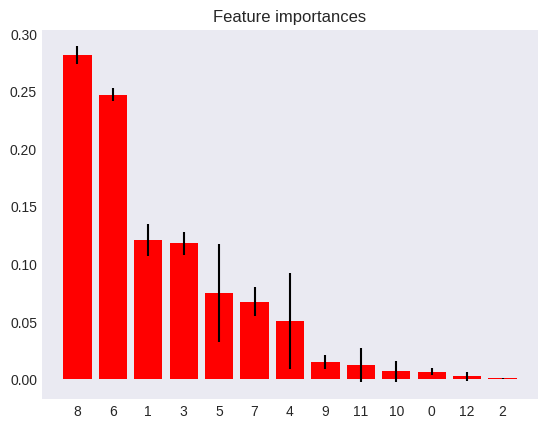

In [27]:
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# print the feature ranking

print('Feature ranking')

df = pd.DataFrame()

for i, j in zip(x_train_n, forest.feature_importances_):
    
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

**Variaveis independentes selecionadas de acordo com sua importância:**

- vintage
- annual_premium
- region_code
- age
- vehicle_damage
- policy_sales_channel
- previously_insured

## Machine Learning

In [28]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
                 'policy_sales_channel', 'previously_insured']

x_train = df_train[cols_selected]

df_val = pd.concat([x_validation, y_validation], axis=1)
x_val = df_val[cols_selected]
y_val = y_validation.values

### KNN

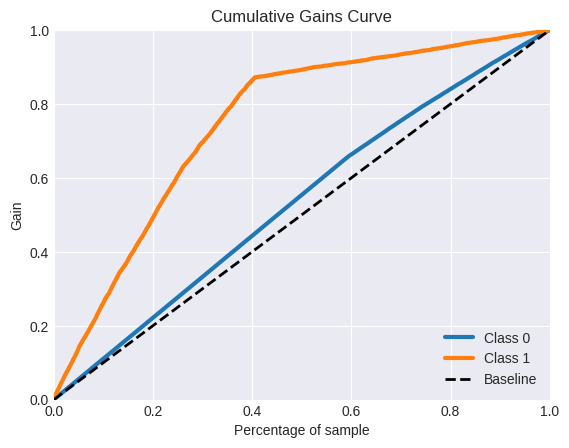

In [29]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

#model prediction - PODER DE GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(x_val)

yhat_knn_pred = knn_model.predict(x_val)

# metrica de ordenação 
# accumulative gain

skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

Em 20% dos clientes (x), contém ~50% de todos os interessados em seguro veicular. No eixo (y) está ordenado pela probalidade de compra.

### Logistic Regression

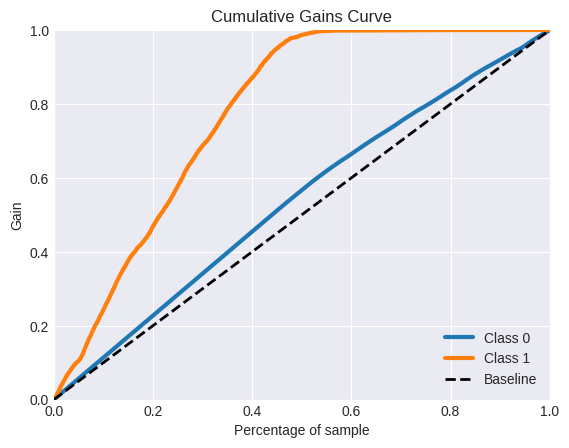

In [30]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42)

# model training 
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

yhat_lr_pred = lr_model.predict(x_val)

# metrica de ordenação 
# accumulative gain

skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

### Random Forest 

In [31]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

yhat_rf_pred = rf_model.predict(x_val)

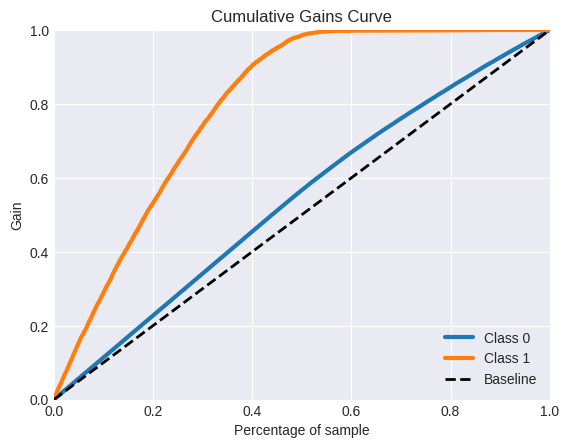

In [32]:
# acumulative gain 
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

## Model Performace

**Precision top k:**
- Irá responder a seguinte pergunta:

    - De todos os K (exemplos) que previ Verdadeiro, quantos realmente eram verdadeiros?


**Recall top k:**
- Irá responder a seguinte perguntas:

    - De todos os exemplos que eram realmente VERDADEIROS, quantos eu previ que eram VERDADEIROS?

In [33]:
y_model = [yhat_knn, yhat_lr, yhat_rf]

precision_list = []
recall_list = []
accuracy_list = []

for model in y_model:

    # copy data
    df4 = x_val.copy()
    df4['response'] = y_val.copy()

    # propensity score
    df4['score'] = model[:,1].tolist()

    # sorte clients by propensity score
    df4 = df4.sort_values('score', ascending= False)

    # compute precision at k
    precision = precision_at_k(df4, k=1000)
    precision_list.append(precision)

    # compute precision at k
    recall = recall_at_k(df4, k=1000)
    recall_list.append(recall)

    
y_model_pred = [yhat_knn_pred, yhat_lr_pred, yhat_rf_pred]

for pred in y_model_pred:
    
    # accuracy
    accuracy = accuracy_score(y_val, pred)
    accuracy_list.append(accuracy)
    


In [34]:
performace = {'Model': ['KNN', 'Logistic Regression', 'Random Forest'],
              'Precision': precision_list,
              'Recall': recall_list,
              'Accuracy': accuracy_list}

df_performace = pd.DataFrame(performace)

df_performace

,Model,Precision,Recall,Accuracy
0,KNN,0.352647,0.047962,0.862541
1,Logistic Regression,0.300699,0.040897,0.879301
2,Random Forest,0.372627,0.050679,0.868297


## Cross Validation

- Realiza o Cross Validation, pois para melhor performace de aprendizado nesse caso de classificação de classes binária é preferivel uma amostragem estratificada. Tendo uma divisão de correta proporção das classes.

In [38]:
# definition model
knn = nh.KNeighborsClassifier(n_neighbors = 7)
lr = lm.LogisticRegression( random_state = 42)
rf = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [39]:
knn_cv = cross_validation('KNN', knn, X_train, Y_train, 1000, verbose=False)
lr_cv = cross_validation('Logistic Regression', lr, X_train, Y_train, 1000, verbose=False)
rf_cv = cross_validation('Random Forest', rf, X_train, Y_train, 1000, verbose=False)

results_cv = pd.concat([knn_cv, lr_cv, rf_cv])

In [40]:
results_cv

,Precision @k CV,Recall @k CV,Accuracy
KNN,0.35,0.047,0.861
Logistic Regression,0.31,0.041,0.877
Random Forest,0.35,0.047,0.866


## Hyperparameters fine tuning

- Para descobrir o meu parametro do modelo escolhido, utilizarei o dataset de validação.

In [41]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
                 'policy_sales_channel', 'previously_insured']

x_val = df_val[cols_selected]
y_val = y_validation.values

### GridSearch

In [42]:
param_grid = {
    'n_estimators': [1000,1500, 1700, 2500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [43]:
grid_search = GridSearchCV(en.RandomForestClassifier(),
                            param_grid=param_grid)

grid_search.fit(x_val, y_val)

print(grid_search.best_estimator_)


RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=1000)


**Melhor parametro do GridSearch**

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=1000)

## Treinando o Modelo Random Forest

- Treinando o modelo com o dataset do Treino(60%) + Validation(20%).
- Os melhores parametros selecionados pelo GridSearch

In [44]:
x_test, y_test = preprocessing_cv(x_test, y_test)

In [48]:
X_train, Y_train = preprocessing_cv(X_train, Y_train)

In [49]:
X_train.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
76393,0.072664,0.207106,0.600000,0.126842,1,0.194199,0
231045,0.107266,0.900523,0.369231,0.188786,0,0.208754,1
296020,0.463668,0.235316,0.030769,0.061728,1,0.352923,0
261238,0.183391,-0.370906,0.061538,0.061798,0,0.352923,1
158340,0.349481,0.782030,0.169231,0.070341,0,0.352923,1


In [50]:
# model definition
rf_model_final = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, 
                                     max_depth=3, max_leaf_nodes=3)

# model training
rf_model_final.fit(X_train, Y_train)

# model prediction
yhat_rf = rf_model_final.predict_proba(x_test)

yhat_rf_pred = rf_model_final.predict(x_test)

In [51]:

# copy data
df_final = x_test.copy()
df_final['response'] = y_test.copy()

# propensity score
df_final['score'] = yhat_rf[:,1].tolist()

# sorte clients by propensity score
df_final = df_final.sort_values('score', ascending= False)

# compute precision at k
precision = precision_at_k(df_final, k=1000)

# compute precision at k
recall = recall_at_k(df_final, k=1000)

# accuracy
accuracy = accuracy_score(y_test, yhat_rf_pred)



In [52]:
performace = {'Model': 'Random Forest',
              'Precision': [precision],
              'Recall': [recall],
              'Accuracy': [accuracy]}

df_performace = pd.DataFrame(performace)

df_performace

,Model,Precision,Recall,Accuracy
0,Random Forest,0.34965,0.037821,0.878591


## Performace de Negócio

A solução do problema de negócio é apresentar uma lista ordenada de clientes mais propensos a aceitar a oferta da campanha de adiquirir um novo porduto da empresa, seguro de automovel, pois o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.

- Logo, de acordo com o modelo ligando para os 20mil clientes teremos 65% de clientes interessados, sendo aproximadamente 2,5 vezes melhor que fazendo ligações aleatórias.

In [54]:
# compute precision at k
precision = precision_at_k(df_final, k=20000)

# compute precision at k
recall = recall_at_k(df_final, k=20000)

# accuracy
accuracy = accuracy_score(y_test, yhat_rf_pred)

performace = {'Model': 'Random Forest',
              'Precision': [precision],
              'Recall': [recall],
              'Accuracy': [accuracy]}

df_performace = pd.DataFrame(performace)

df_performace

,Model,Precision,Recall,Accuracy
0,Random Forest,0.300485,0.649449,0.878591


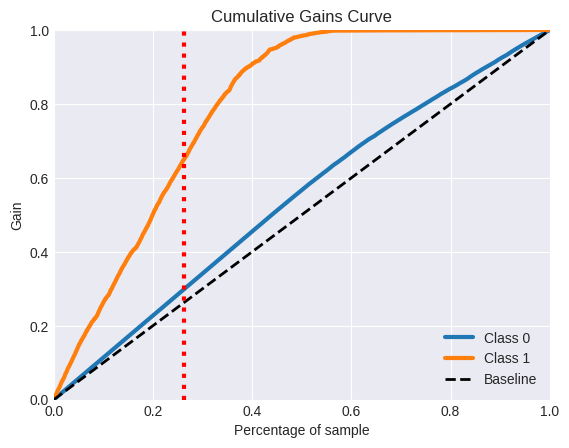

In [55]:
# acumulative gain 
skplt.metrics.plot_cumulative_gain(y_test, yhat_rf)
plt.axvline(20000/len(df_final), 0, 1, color='red', ls=':', lw=3)
plt.show();

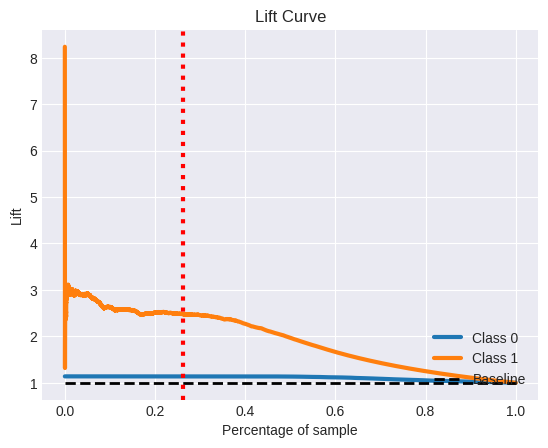

In [56]:
skplt.metrics.plot_lift_curve(y_test, yhat_rf)
plt.axvline(20000/len(df_final), 0, 1, color='red', ls=':', lw=3)
plt.show()

**Modelo escolhido foi Random Forest.**

In [59]:
# Salvar o modelo final

pickle.dump(rf_model_final, open('../web_app/models/rf_model_final.pkl', 'wb'))